### EDA on fastMRI dataset

In [1]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
from fastMRI.data import transforms as T

In [2]:
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR, "data")
train_h5_files = glob.glob(os.path.join(TRAIN_DATASET_PATH,'singlecoil_train','*.h5'))
len(train_h5_files)

10

In [3]:
def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [4]:
train_h5_files[1]

'/home/hasib/fastmri2019/data/singlecoil_train/file1000027.h5'

In [6]:
file = train_h5_files[5]
hf = h5py.File(file)
print(type(hf))

<class 'h5py._hl.files.File'>


In [7]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00023201829396174764, 'norm': 0.05345318642238667, 'patient_id': 'bb1040a06de5f44bc4dd20af75090352322f7a238c430f55d5e29b3b31c9d156'}


In [8]:
v_k = hf['kspace'][()]
print(v_k.shape)

(36, 640, 372)


In [9]:
def recon_kspace(vol):
    kspace_tensor = T.to_tensor(v_k)      # Convert from numpy array to pytorch tensor
    comp_img = T.ifft2(kspace_tensor)           # Apply Inverse Fourier Transform to get the complex image
    real_img = T.complex_abs(comp_img)   # Compute absolute value to get a real image
    image_rss = T.root_sum_of_squares(real_img, dim=0)
    recon_kspace_img = np.abs(image_rss.numpy())
    return recon_kspace_img


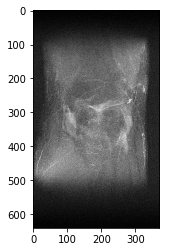

In [10]:
img = recon_kspace(v_k)
plt.imshow(img, cmap='gray')

In [11]:
slice_kspace2 = T.to_tensor(v_k)      # Convert from numpy array to pytorch tensor
slice_image = T.ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = T.complex_abs(slice_image)   # Compute absolute value to get a real image

In [12]:
slice_image_rss = T.root_sum_of_squares(slice_image_abs, dim=0)
slice_image_rss.shape

torch.Size([640, 372])

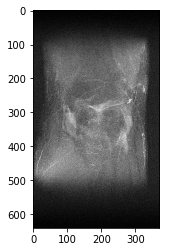

In [13]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

In [16]:
slice_kspace = v_k[20]
slice_kspace.shape

(640, 372)

In [17]:
x = np.log(np.abs(slice_kspace) + 1e-9)
x.shape

(640, 372)

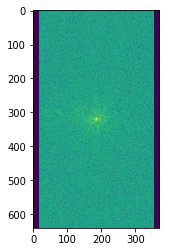

In [18]:
plt.imshow(x)

### Ground truth

In [19]:
gt = hf['reconstruction_rss']
gt.shape

(36, 320, 320)

In [20]:
a = gt[1]
a.shape

(320, 320)

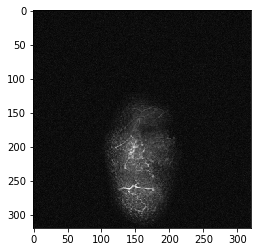

In [21]:
plt.imshow(a, cmap='gray')

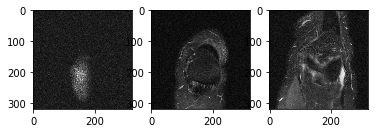

In [22]:
show_slices(gt, [0, 5, 10], cmap='gray')

In [23]:
b = hf['reconstruction_rss']
b.shape

(36, 320, 320)

In [24]:
c = b[1]
c.shape

(320, 320)

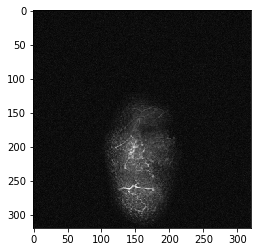

In [25]:
plt.imshow(c, cmap='gray')

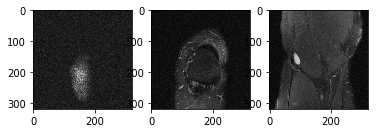

In [26]:
show_slices(b, [0, 5, 35], cmap='gray')

In [27]:
from fastMRI.data import transforms as T

In [28]:
def gt_full_img(vol):    
    # convert hdf5 dataset input volume to numpy arr
    vol = np.array(vol)
    # convert numpy array to pytorch tensor
    slice_kspace2 = T.to_tensor(vol)
    # combine slices into full image
    slice_image_rss = T.root_sum_of_squares(slice_kspace2, dim=0)
    # convert image to numpy
    recon_img = np.abs(slice_image_rss.numpy())
    return recon_img

In [29]:
img = gt_full_img(gt)
img.shape

(320, 320)

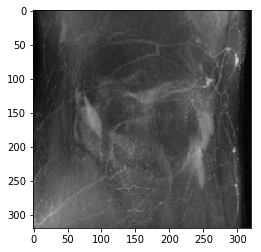

In [31]:
plt.imshow(img, cmap="gray")

In [32]:
# convert hdf5 dataset input volume to numpy arr
b = np.array(b)
slice_kspace2 = T.to_tensor(b)
#slice_kspace2.shape

In [33]:
slice_image_rss = T.root_sum_of_squares(slice_kspace2, dim=0)
slice_image_rss.shape

torch.Size([320, 320])

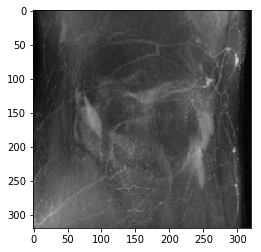

In [34]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

In [35]:
img = np.abs(slice_image_rss.numpy())
img.shape

(320, 320)

In [36]:
from fastMRI.common.subsample import MaskFunc
mask_func = MaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [37]:
v_k.shape

(36, 640, 372)

In [38]:
type(v_k)

numpy.ndarray

In [39]:
slice_kspace2 = T.to_tensor(v_k)
slice_kspace2.shape

torch.Size([36, 640, 372, 2])

In [40]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

In [41]:
sampled_image = T.ifft2(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = T.complex_abs(sampled_image)   # Compute absolute value to get a real image
# compute RSS to add all slices to one image
crop = T.center_crop(sampled_image_abs, (320, 320))
print(crop.shape)

sampled_image_rss = T.root_sum_of_squares(crop, dim=0)
sampled_image_rss.shape

torch.Size([36, 320, 320])


torch.Size([320, 320])

In [42]:
# convert torch tensor to numoy
img = np.abs(sampled_image_rss.numpy())
img.shape

(320, 320)

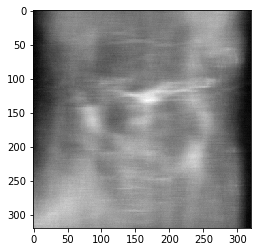

In [43]:
plt.imshow(img, cmap='gray')

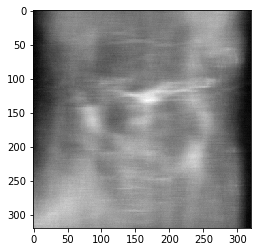

In [44]:
plt.imshow(img, cmap='gray')

In [45]:
def sub_sample_kspace(vol, mask_func):
    '''
    Transform a kpsace tensor to an undersampled image using mask object 4x or 8x
    
    INPUT
    vol: kspace tensor
    mask_func: mask function object (4x, 8x)
    
    OUTPUT
    sample_image_rss: output undersampled image
    '''
    
    # convert numpy to torch tensor
    kspace2ttensor = T.to_tensor(v_k)
    # apply mask to kspace
    masked_kspace, mask = T.apply_mask(kspace2ttensor, mask_func)   
    # inverse FT
    sampled_image = T.ifft2(masked_kspace)
    # compute absolute value to get a real image
    sampled_image_abs = T.complex_abs(sampled_image)
    # centre crop
    cropped_image = T.center_crop(sampled_image_abs, (320, 320))
    
    # compute RSS to add all slices to one image
    sampled_image_rss = T.root_sum_of_squares(cropped_image, dim=0)
    sampled_image_rss = np.abs(sampled_image_rss.numpy())
    return sampled_image_rss

In [46]:
from fastMRI.common.subsample import MaskFunc
mask_func = MaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [47]:
v_k.shape

(36, 640, 372)

In [48]:
img = sub_sample_kspace(v_k, mask_func)
img.shape

(320, 320)

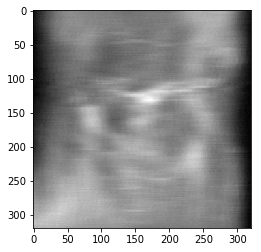

In [49]:
plt.imshow(img, cmap='gray')

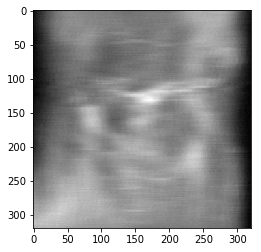

In [50]:
plt.imshow(img, cmap='gray')

In [51]:
img

array([[3.9933158e-05, 4.2381951e-05, 4.0457246e-05, ..., 4.5916102e-05,
        4.4508550e-05, 4.2103056e-05],
       [3.3239525e-05, 3.6367856e-05, 3.8094200e-05, ..., 4.7920286e-05,
        4.5357268e-05, 4.1706633e-05],
       [3.5110534e-05, 3.7138001e-05, 3.7055521e-05, ..., 4.6885936e-05,
        4.6337351e-05, 4.5871220e-05],
       ...,
       [1.9560753e-04, 1.9389509e-04, 1.9400602e-04, ..., 2.8454859e-05,
        2.8922419e-05, 2.7194699e-05],
       [1.9861829e-04, 1.9789347e-04, 2.0212769e-04, ..., 2.7136950e-05,
        2.5432157e-05, 2.8599030e-05],
       [1.9383871e-04, 1.9339366e-04, 1.9128117e-04, ..., 2.7404207e-05,
        2.7176384e-05, 3.0031228e-05]], dtype=float32)

In [52]:
type(img)

numpy.ndarray